<a href="https://colab.research.google.com/github/robd123/AML/blob/main/Project5/Project5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import urllib.request
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import graphviz
from matplotlib import figure, pyplot
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [48]:
datapath = os.path.join("datasets", "letters", "")
os.makedirs(datapath, exist_ok=True)

# Dataset is already split into test and train data
file_path = "https://raw.githubusercontent.com/bforoura/AML/master/letters.csv"

urllib.request.urlretrieve(file_path, datapath + "letters.csv")
letter_data = pd.read_csv(datapath + "letters.csv", thousands=',')
letter_data['class'] = pd.Categorical(letter_data["class"])

print(letter_data.shape)
print(letter_data.head())

(20000, 17)
   x-box  y-box  width  high  onpix  ...  x-ege  xegvy  y-ege  yegvx  class
0      2      4      4     3      2  ...      1      8      5      6      Z
1      4      7      5     5      5  ...      2      9      7     10      P
2      7     10      8     7      4  ...      2      5      5     10      S
3      4      9      5     7      4  ...      3      8      0      8      H
4      6      7      8     5      4  ...      3      8      3      7      H

[5 rows x 17 columns]


In [3]:
print(letter_data.dtypes)

x-box       int64
y-box       int64
width       int64
high        int64
onpix       int64
x-bar       int64
y-bar       int64
x2bar       int64
y2bar       int64
xybar       int64
x2ybr       int64
xy2br       int64
x-ege       int64
xegvy       int64
y-ege       int64
yegvx       int64
class    category
dtype: object


**Look for Missing Data**

---
None found, no need to impute missing data


In [5]:
print(letter_data.isnull().sum())

x-box    0
y-box    0
width    0
high     0
onpix    0
x-bar    0
y-bar    0
x2bar    0
y2bar    0
xybar    0
x2ybr    0
xy2br    0
x-ege    0
xegvy    0
y-ege    0
yegvx    0
class    0
dtype: int64


**Verify Distribution of Letters**

---
Many samples of each letter exist in the dataset


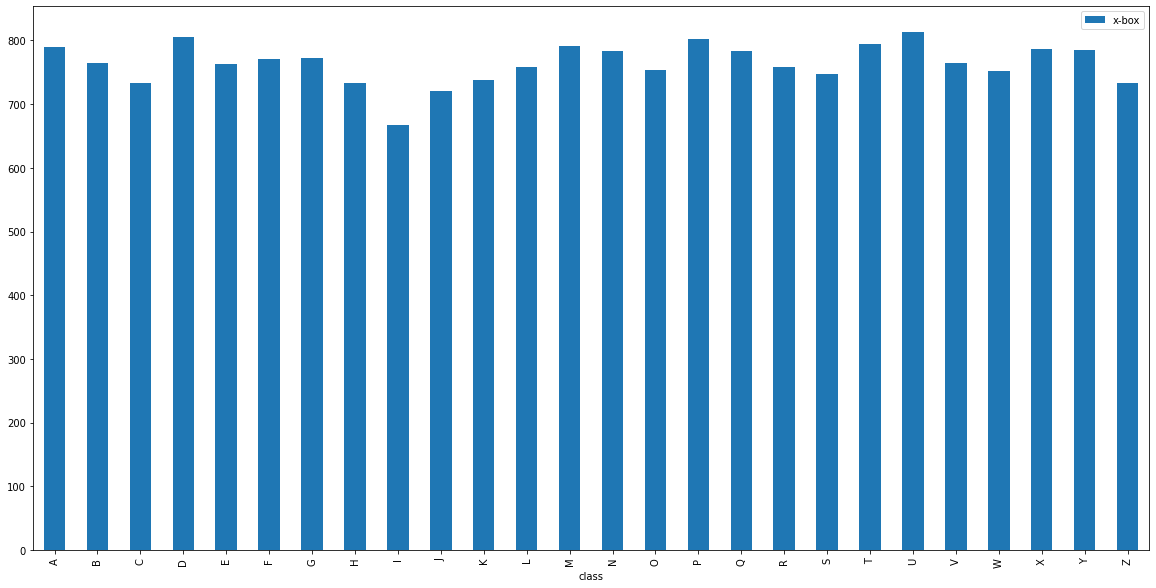

In [49]:
class_pv = pd.pivot_table(letter_data, values='x-box', index=['class'], aggfunc=np.count_nonzero)
class_plot = class_pv.plot(kind='bar', figsize=(20,10))

**Define Cross-Validation Function**

In [50]:
def cross_validate_model (classifier_model, X, y):
  kfold = KFold(n_splits=3, shuffle=True, random_state=10)

  # perform model cross validation on the shuffled folds
  results = cross_val_score(classifier_model, X, y, cv=kfold)

  # return the mean score for all folds
  return results.mean()

**Define Preprocessor to Scale and Encode Features**


---
Earlier it was determined that there are no missing values, so an imputer is not needed


In [51]:


# Categorical and Float Attributes
cats = ['class']
floats = ['x-box', 'y-box', 'width', 'high', 'onpix', 'x-bar', 'y-bar', 'x2bar', 'y2bar', 'xybar', 'x2ybr', 'xy2br', 'x-ege', 'xegvy', 'y-ege', 'yegvx', ]

# Create pipeline to change categorical data to ordinal data
cat_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())
])
# Create pipeline to scale continuous data
float_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('float', float_transformer, floats),
        ('cat', cat_transformer, cats)
])

In [52]:
letter_data_proc = pd.DataFrame(preprocessor.fit_transform(letter_data), columns = letter_data.columns)
print(letter_data_proc.head())

      x-box     y-box     width      high  ...     xegvy     y-ege     yegvx  class
0 -1.057698 -0.918603 -0.556881 -1.049137  ... -0.219082  0.509640 -1.113619   25.0
1 -0.012309 -0.010743 -0.060486 -0.164704  ...  0.427463  1.288757  1.359441   15.0
2  1.555774  0.897117  1.428701  0.719730  ... -2.158715  0.509640  1.359441   18.0
3 -0.012309  0.594497 -0.060486  0.719730  ... -0.219082 -1.438153  0.122911    7.0
4  1.033079 -0.010743  1.428701 -0.164704  ... -0.219082 -0.269477 -0.495354    7.0

[5 rows x 17 columns]


In [53]:
Y = letter_data_proc[['class']]
X = letter_data_proc.drop(columns=['class'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)  # Use 80/20 split

In [ ]:
tree_classifier = DecisionTreeClassifier()

params = { 'criterion':['gini','entropy'], 'max_depth': np.arange(3, 25), 'min_samples_leaf': np.arange(1, 10), 'min_samples_split': np.arange(2, 10)}
   
grid_search_dt = GridSearchCV(tree_classifier, params, cv=3, n_jobs=-1)

grid_search_dt.fit(X_train, Y_train)

print(grid_search_dt.best_params_)


{'criterion': 'entropy', 'max_depth': 23, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [54]:
tree_classifier_opt = DecisionTreeClassifier(criterion='entropy', max_depth=23, min_samples_leaf=1, min_samples_split=2)
tree_classifier_opt.fit(X_train, Y_train)

Y_pred_dt = tree_classifier_opt.predict(X_test)
dt_accuracy = accuracy_score(Y_test, Y_pred_dt)

dt_score = cross_validate_model(tree_classifier_opt, X_train, Y_train)

print(dt_accuracy)
print(dt_score)

0.8795
0.8575002332471428


In [55]:
sgd_classifier = SGDClassifier()
sgd_classifier.fit(X_train, Y_train)

Y_pred_sgd = sgd_classifier.predict(X_test)
sgd_accuracy = accuracy_score(Y_test, Y_pred_sgd)

sgd_score = cross_validate_model(sgd_classifier, X_train, Y_train)

print(sgd_accuracy)
print(sgd_score)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

0.64725
0.6113130945824722


In [56]:
random_forest_entr = RandomForestClassifier(criterion='entropy', n_estimators=500, n_jobs=-1)
random_forest_entr.fit(X_train, Y_train)

Y_pred_entr = random_forest_entr.predict(X_test)
entr_accuracy = accuracy_score(Y_test, Y_pred_entr)

random_forest_entr_score = cross_validate_model(random_forest_entr, X_train, Y_train)

print(entr_accuracy)
print(random_forest_entr_score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sample

0.9605
0.9554378199443615


In [57]:
random_forest_gini = RandomForestClassifier(criterion='gini', n_estimators=500, n_jobs=-1)
random_forest_gini.fit(X_train, Y_train)

Y_pred_gini = random_forest_gini.predict(X_test)
gini_accuracy = accuracy_score(Y_test, Y_pred_gini)

random_forest_gini_score = cross_validate_model(random_forest_gini, X_train, Y_train)

print(gini_accuracy)
print(random_forest_gini_score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sample

0.961
0.9565003980727798


In [89]:
svc_classifier = SVC()
params = {'kernel':['rbf'], 'gamma':['scale','auto'], 'C': np.arange(10, 30)}

grid_search = GridSearchCV(svc_classifier, params,  cv=3, n_jobs=-1)
grid_search.fit(X_train, Y_train)
print(grid_search.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 17, 'gamma': 'auto', 'kernel': 'rbf'}


In [91]:
rbf_svc_classifier = SVC(kernel='rbf', C=17, gamma='auto')
rbf_svc_classifier.fit(X_train, Y_train)

Y_pred_svc = rbf_svc_classifier.predict(X_test)
svc_accuracy = accuracy_score(Y_test, Y_pred_svc)

rbf_svc_score = cross_validate_model(rbf_svc_classifier, X_train, Y_train)

print(svc_accuracy)
print(rbf_svc_score)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

0.968
0.963812534871356


In [59]:
log_classifier = LogisticRegression(max_iter=1000)
log_classifier.fit(X_train, Y_train)

Y_pred_log = log_classifier.predict(X_test)
log_accuracy = accuracy_score(Y_test, Y_pred_log)

log_score = cross_validate_model(log_classifier, X_train, Y_train)

print(log_accuracy)
print(log_score)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

0.773
0.7725001935230625


In [60]:
bag_classifier = BaggingClassifier(DecisionTreeClassifier(), n_estimators=1000, bootstrap=True, n_jobs=-1, oob_score=True)
bag_classifier.fit(X_train, Y_train)

Y_pred_bag = bag_classifier.predict(X_test)
bag_accuracy = accuracy_score(Y_test, Y_pred_bag)

bag_score = cross_validate_model(bag_classifier, X_train, Y_train)

print(bag_accuracy)
print(bag_score)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

0.944
0.9388132104150774


In [65]:
ada_classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=1000, learning_rate=0.1)
ada_classifier.fit(X_train, Y_train)

Y_pred_ada = ada_classifier.predict(X_test)
ada_accuracy = accuracy_score(Y_test, Y_pred_ada)

ada_score = cross_validate_model(ada_classifier, X_train, Y_train)

print(ada_accuracy)
print(ada_score)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

0.831
0.8404375104715136


In [64]:
dt_clf = DecisionTreeClassifier(criterion='entropy')
rf_clf = RandomForestClassifier(criterion='gini')
sv_clf = SVC(kernel='rbf', C=17, gamma='auto')
lg_clf = LogisticRegression(max_iter=1000)
sg_clf = SGDClassifier()

estimators = [('dt', dt_clf), ('rf', rf_clf), ('sv', sv_clf), ('lg', lg_clf), ('sg', sg_clf)]

voting_clf = VotingClassifier(estimators=estimators, voting='hard')
voting_clf.fit(X_train, Y_train)

Y_pred_vote = voting_clf.predict(X_test)
vote_accuracy = accuracy_score(Y_test, Y_pred_vote)

vote_score = cross_validate_model(voting_clf, X_train, Y_train)

print(vote_accuracy)
print(vote_score)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

[ 3.  4. 14. ...  8. 24. 25.]
0.929187866611367


In [68]:
accuracy_scores = list()
for clf in (dt_clf, rf_clf, sv_clf, lg_clf, sg_clf, voting_clf):
  clf.fit(X_train, Y_train)
  y_pred = clf.predict(X_test)
  accuracy_scores.append(accuracy_score(Y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMI

   Decision Tree  Random Forest  ...  Stochastic Gradient Descent  Voting
0         0.8805         0.9575  ...                       0.6335   0.935

[1 rows x 6 columns]


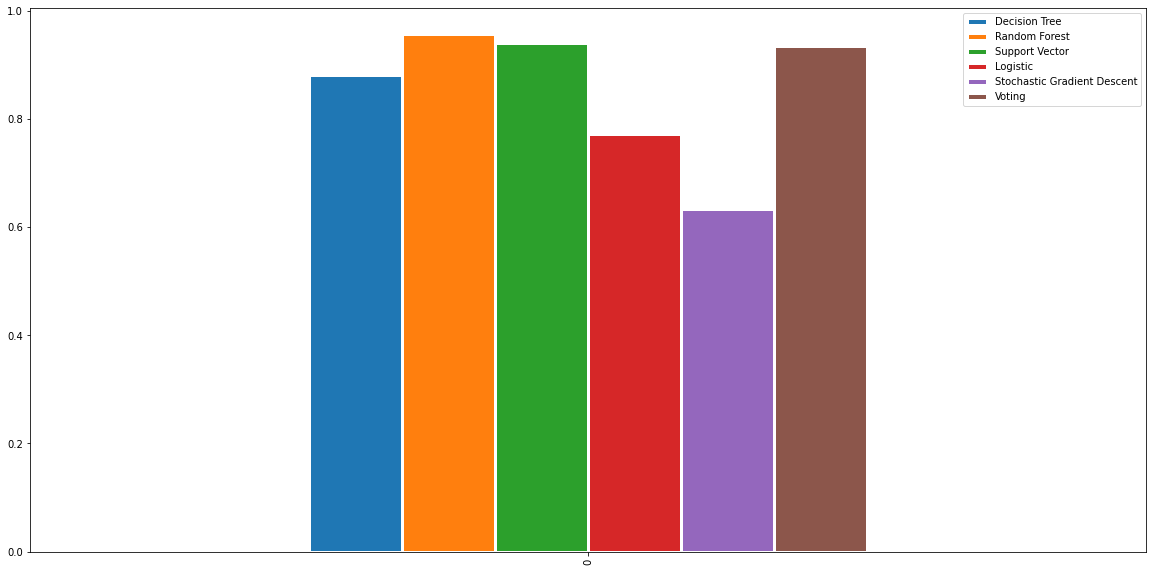

In [86]:
accuracy_df = pd.DataFrame([accuracy_scores], columns=['Decision Tree', 'Random Forest', 'Support Vector', 'Logistic', 'Stochastic Gradient Descent', 'Voting'])
print(accuracy_df)
accuracy_df.plot(kind='bar', figsize=(20, 10), edgecolor='white', linewidth=3)

In [85]:
ada_classifier_2 = AdaBoostClassifier(RandomForestClassifier(), n_estimators=1000, learning_rate=0.1)
ada_classifier_2.fit(X_train, Y_train)

Y_pred_ada = ada_classifier_2.predict(X_test)
ada_accuracy_2 = accuracy_score(Y_test, Y_pred_ada)

ada_score_2 = cross_validate_model(ada_classifier_2, X_train, Y_train)

print(ada_accuracy_2)
print(ada_score_2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

0.958
0.9534377300906015


In [81]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=1000, bootstrap=True, n_jobs=-1, oob_score=True)
ada_clf = AdaBoostClassifier(RandomForestClassifier(), n_estimators=1000, learning_rate=0.1)
rf_clf_2 = RandomForestClassifier(criterion='gini')
sv_clf_2 = SVC(kernel='rbf', C=17, gamma='auto')


estimators = [('bag', bag_clf), ('rf', rf_clf_2), ('sv', sv_clf_2)]

voting_clf_2 = VotingClassifier(estimators=estimators, voting='hard')
voting_clf_2.fit(X_train, Y_train)

Y_pred_vote = voting_clf_2.predict(X_test)
vote_accuracy = accuracy_score(Y_test, Y_pred_vote)

vote_score = cross_validate_model(voting_clf_2, X_train, Y_train)

print(vote_accuracy)
print(vote_score)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

0.959
0.9545629293056912


In [82]:
accuracy_scores_2 = list()
for clf in (bag_clf, rf_clf_2, sv_clf_2, voting_clf_2):
  clf.fit(X_train, Y_train)
  y_pred = clf.predict(X_test)
  accuracy_scores_2.append(accuracy_score(Y_test, y_pred))

   Bagging  Random Forest  Support Vector   Voting
0    0.944          0.962          0.9405  0.95675


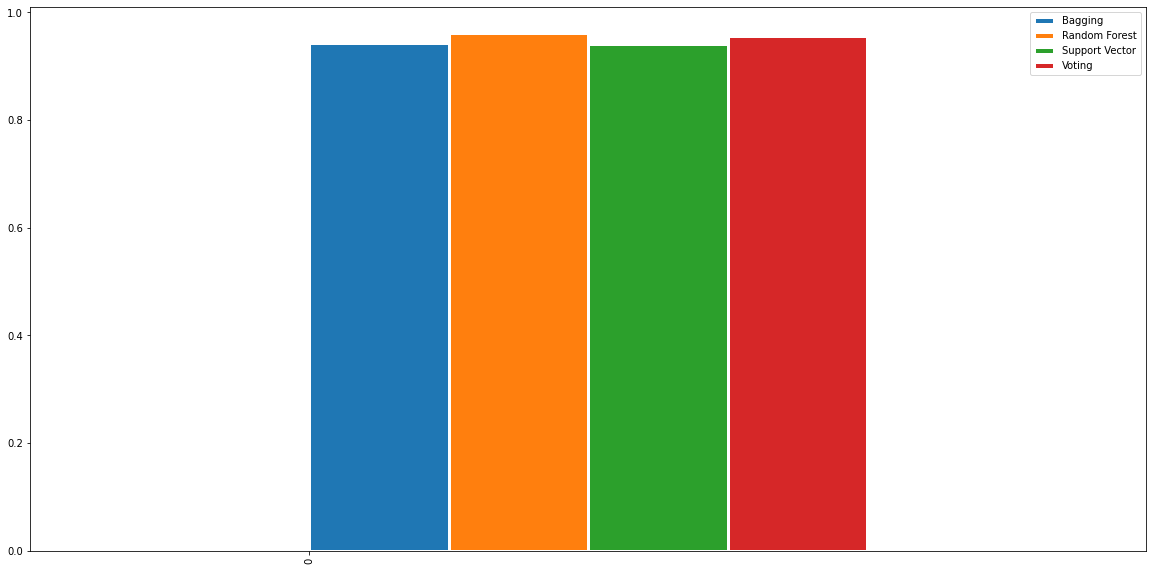

In [83]:
accuracy_df_2 = pd.DataFrame([accuracy_scores_2], columns=['Bagging', 'Random Forest', 'Support Vector', 'Voting'])
print(accuracy_df_2)
accuracy_df_2.plot(kind='bar', figsize=(20, 10), edgecolor='white', linewidth=3, align = 'edge')